In [1]:
import os 
import struct
import numpy as np
import shutil
import csv

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

from scipy.special import kv  #modified bessel function

In [2]:
def parse_string(input_string):
    try:
        # Try to parse as an int 
        result = int(input_string)
    except ValueError:
        try:
            # try parsing as a float
            result = float(input_string)
        except ValueError:
            # keep it as a string
            result = input_string
    return result

class configIni:
    def __init__(self, filename="../params"):
        self.data = {}
        self.filename = filename
        self.grabParams()
    def __getitem__(self,key):
        return self.data[key]
    def __setitem__(self,key,value):
        self.data[key] = value
    def __len__(self):
        return len(self.data)
    def __str__(self):
        return str(self.data)
    def __iter__(self):
        return iter(self.data)
    def keys(self):
        return self.data.keys()
    def grabParams(self):
        try:
            with open(self.filename, 'r') as file:
                for line in file:
                    if (not line.startswith('#')) or (not line.startswith('[')):
                        items = line.strip().split()
                        if len(items) == 3:
                            key, non, val = items
                            self.data[key] = parse_string(val)
        except FileNotFoundError:
            print(f"File '{self.filename}' not found.")
        except Exception as e:
            print(f"An error occurred: {str(e)}")
    def echoParams(self):
        for key in self.data.keys():
            print(key,':',self.data[key])
            


In [3]:
hbarc = 0.197327

def readOBin(conf, binPath):
    with open(binPath, 'rb') as file:
        binary_data = file.read()
    num_floats = len(binary_data) // 4
    dat = np.array(struct.unpack(f'{num_floats}f', binary_data))
    conf['TPts'] = len(dat) // (conf['XPts']*conf['YPts']*conf['ZPts'])
    return np.array( np.array_split(np.array_split(np.array_split(dat, conf['TPts']*conf['XPts']*conf['YPts']), conf['TPts']*conf['XPts']), conf['TPts']) )

def fl(n):
    return int(np.floor(n))

def plotCentral(conf, bA):
    ti = np.arange(conf['TPts'])
    tPts = np.linspace(conf['TauMin'], conf['TauMin']+(conf['TauStepSize']*conf['RecordingFrequency']*conf['TPts']), conf['TPts'])
    #print(bA[ti, fl(conf['XPts']/2), fl(conf['YPts']/2), fl(conf['ZPts']/2)])
    plt.plot(tPts ,bA[ti, fl(conf['XPts']/2), fl(conf['YPts']/2), fl(conf['ZPts']/2)])
    plt.xlabel('tau [fm/c]')
    plt.ylabel('T [fm-1]')
    plt.title('Central temp')
    plt.show()
    
def getTCent(conf, bA):
    ti = np.arange(conf['TPts'])
    tPts = np.linspace(conf['TauMin'], conf['TauMin']+(conf['TauStepSize']*conf['RecordingFrequency']*conf['TPts']), conf['TPts'])
    #print(np.array([tPts ,bA[ti, fl(conf['XPts']/2), fl(conf['YPts']/2), fl(conf['ZPts']/2)]]).T)
    return np.array([tPts ,bA[ti, fl(conf['XPts']/2), fl(conf['YPts']/2), fl(conf['ZPts']/2)]]).T
    
def seq(T, m):
    Ndof = 3
    meq = m/T
    return 4*np.pi*(Ndof/np.power(2*np.pi,3))*np.power(T,3)*np.power(meq,2)*((4*kv(2,meq))+(meq*kv(1,meq)))

def getEntropyFt(conf, bA, mI):
    tP = np.arange(conf['TPts'])
    tPts = np.linspace(conf['TauMin'], conf['TauMin']+(conf['TauStepSize']*conf['RecordingFrequency']*conf['TPts']), conf['TPts'])
    sL = []
    for ti in tP:
        Ti = bA[ti].flatten()
        Tbool = np.heaviside(Ti-(conf['FinalTemperature']/hbarc),0)
        v = np.sum(Tbool * seq(Ti ,mI(Ti))) # heav(T>FinalTemperature) * seq
        sL.append([tPts[ti], v*conf['XSpacing']*conf['YSpacing']*conf['ZSpacing']*tPts[ti]]) # multiply by volume element size
    return np.array(sL) 

def getAvgEntropyInFt(conf, bA, mI):
    tP = np.arange(conf['TPts'])
    tPts = np.linspace(conf['TauMin'], conf['TauMin']+(conf['TauStepSize']*conf['RecordingFrequency']*conf['TPts']), conf['TPts'])
    sL = []
    for ti in tP:
        Ti = bA[ti].flatten()
        Tbool = np.heaviside(Ti-(conf['FinalTemperature']/hbarc),0)
        v = np.sum(Tbool * seq(Ti ,mI(Ti)))/np.sum(Tbool) # heav(T>FinalTemperature) * seq
        sL.append([tPts[ti], v]) # ^^^ mean to get avg entropy in freezeout
    return np.array(sL)

def getAvgTempInFt(conf, bA):
    tP = np.arange(conf['TPts'])
    tPts = np.linspace(conf['TauMin'], conf['TauMin']+(conf['TauStepSize']*conf['RecordingFrequency']*conf['TPts']), conf['TPts'])
    sL = []
    for ti in tP:
        Ti = bA[ti].flatten()
        Tbool = np.heaviside(Ti-(conf['FinalTemperature']/hbarc),0)
        v = np.sum(Tbool * Ti)/np.sum(Tbool) # heav(T>FinalTemperature) * seq
        sL.append([tPts[ti], v]) # ^^^ sum(T>Tfin)/Nelems(T>Tfin) to get avg temp in freezeout
    return np.array(sL)

def getCentralEntropy(conf, bA, mI):
    ti = np.arange(conf['TPts'])
    tPts = np.linspace(conf['TauMin'], conf['TauMin']+(conf['TauStepSize']*conf['RecordingFrequency']*conf['TPts']), conf['TPts'])
    Ti = bA[ti, fl(conf['XPts']/2), fl(conf['YPts']/2), fl(conf['ZPts']/2)]
    si = seq(Ti, mI(Ti))
    #print(si)
    return np.array([tPts, si]).T

def getVFrac(conf, bA):
    tP = np.arange(conf['TPts'])
    tPts = np.linspace(conf['TauMin'], conf['TauMin']+(conf['TauStepSize']*conf['RecordingFrequency']*conf['TPts']), conf['TPts'])
    sL = []
    for ti in tP:
        Ti = bA[ti].flatten()
        Tbool = np.heaviside(Ti-(conf['FinalTemperature']/hbarc),0)
        v = np.sum(Tbool) # heav(T>FinalTemperature)
        sL.append([tPts[ti], v/(conf['XPts']*conf['YPts']*conf['ZPts'])]) # ^^^ Nelems(T>Tfin)/Nelems to get vol frac
    return np.array(sL)
        

In [4]:
def readMassData(conf, fp):
    data = []
    with open(fp, 'r', newline='') as file:
        reader = csv.reader(file, delimiter='\t')
        for row in reader:
            data.append(row)
    return np.array(data[2:]).astype(float)

def interpMassD(conf, mD):
    return interp1d(mD[:,0], mD[:,1], kind='cubic')



In [5]:
d = readOBin(ini, './../output/bin/'+targH+'/temp.bin')
plotCentral(ini, d)


mDat = readMassData(ini, '../input/eos/hotqcd/massData.tsv')
intmD = interpMassD(ini, mDat)
x = np.linspace(0.05, 5, 100)
plt.plot(x*hbarc, intmD(x)/x)
plt.xscale('log')
plt.xlabel('T [fm-1]')
plt.ylabel('m(T)/T [fm-1]')
plt.title('Quasiparticle mass')
plt.show()

s = getEntropyFt(ini, d, intmD)
plt.plot(s[:,0],s[:,1])
plt.yscale('log')
plt.xlabel('tau [fm/c]')
plt.ylabel('S_tot [fm-1]')
plt.title('Total entropy in freeze-out volume')
plt.show()

NameError: name 'ini' is not defined

In [6]:
pth = '../output/bin/'
print([d for d in os.listdir(pth) if os.path.isdir(os.path.join(pth, d))])

FileNotFoundError: [Errno 2] No such file or directory: '../output/bin/'

In [7]:
targDir = './run7/7/'
targH = '28BEB95A'

ini = configIni(filename = targDir+'output/bin/'+targH+'/'+targH+'.ini')
ini.echoParams()

JobID : Random
EvaluationMode : 1
FileTSV : 0
FileBIN : 1
Equations : 3
Etabar_type : 0
etabar : 0.159155
Slope1 : 0
Slope2 : 0
Tc : 0.155
Stepper : 1
Smoother : 1
LAXfrac : 0.005
RecordingFrequency : 10
TSVDir : ./output/tsv/
BINDir : ./output/bin/
XMLDir : ./output/xml/
XPts : 64
YPts : 64
ZPts : 64
XSpacing : 0.5
YSpacing : 0.5
ZSpacing : 0.375
TauMin : 0.25
TauMax : 30.25
FinalTemperature : 0.125
TauStepSize : 0.02
EquationOfState : 2
IdealEquationOfStateStatistics : 1
IdealEquationOfStateDegeneracy : 0
IdealEquationOfStateQuarkFlavors : 2
RealisticEquationOfStateDirectory : ./input/eos/wuppertal/
InitialAnisotropy : 1
InitialAnisotropyValue : 1
InitialAX : 1.0
InitialAY : 1.0
InitialAZ : 1.0
InitialSource : 3
InitialTemperature : 0.63
SigmaX : 1
SigmaY : 1
SigmaZ : 1
CollisionEnergy : 5210
PlateauHalfWidth : 2.3
GaussianHalfWidth : 1.6
DensityOfSourcesNormalization : 1
DensityOfSourcesScaling : 2
MixingFactor : 0.15
ShiftInRapidity : 0.0
MCSig0 : 0.46
InelasticCrossSection : 6.2
N

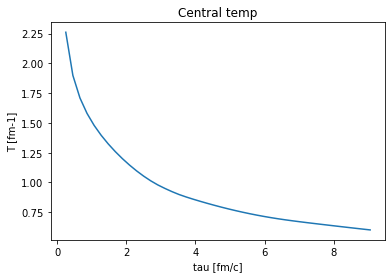

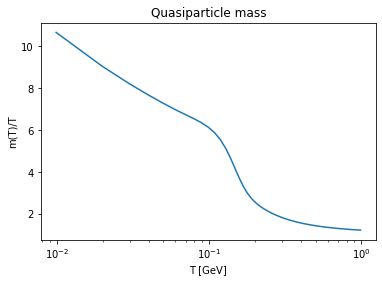

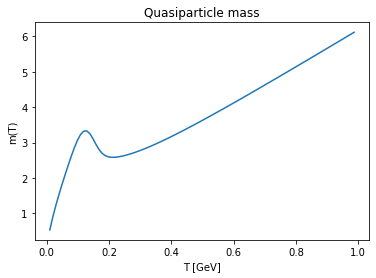

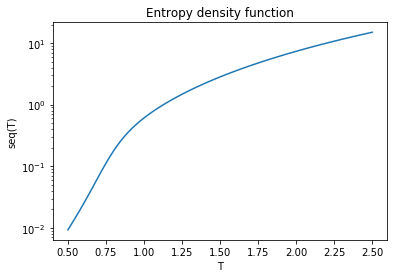

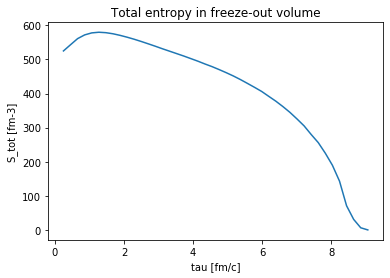

/home/jacob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


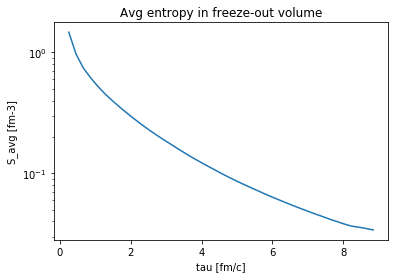

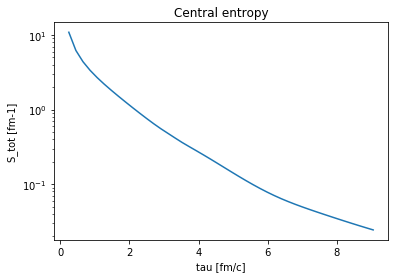

In [8]:
d = readOBin(ini, targDir+'output/bin/'+targH+'/temp.bin')
plotCentral(ini, d)

mDat = readMassData(ini, targDir+ini['RealisticEquationOfStateDirectory'][2:]+'massData.tsv')
intmD = interpMassD(ini, mDat)
x = np.linspace(0.05, 5, 100)
plt.plot(x*hbarc, intmD(x)/x)
plt.xscale('log')
plt.xlabel('T [GeV]')
plt.ylabel('m(T)/T')
plt.title('Quasiparticle mass')
plt.show() #quasiparticle mass


x = np.linspace(0.05, 5, 100)
plt.plot(x*hbarc, intmD(x))
plt.xlabel('T [GeV]')
plt.ylabel('m(T)')
plt.title('Quasiparticle mass')
plt.show() #quasiparticle mass

Ti = np.linspace(0.5, 2.5, 100)
plt.plot(Ti, seq(Ti, intmD(Ti)))
plt.yscale('log')
plt.xlabel('T')
plt.ylabel('seq(T)')
plt.title('Entropy density function')
plt.show() #Entropy density function


s = getEntropyFt(ini, d, intmD)
plt.plot(s[:,0],s[:,1])
plt.xlabel('tau [fm/c]')
plt.ylabel('S_tot [fm-3]')
plt.title('Total entropy in freeze-out volume')
plt.show() #total entropy inside freezeout

sIn = getAvgEntropyInFt(ini, d, intmD)
plt.plot(sIn[:,0],sIn[:,1])
plt.yscale('log')
plt.xlabel('tau [fm/c]')
plt.ylabel('S_avg [fm-3]')
plt.title('Avg entropy in freeze-out volume')
plt.show() #Avg entropy in freezeout

sC = getCentralEntropy(ini, d, intmD)
plt.plot(sC[:,0],sC[:,1])
plt.yscale('log')
plt.xlabel('tau [fm/c]')
plt.ylabel('S_tot [fm-1]')
plt.title('Central entropy')
plt.show() # Central entropy



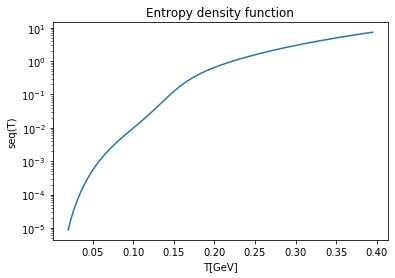

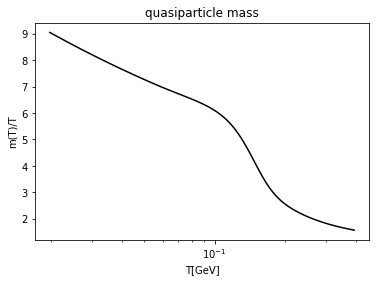

In [9]:
Ti = np.linspace(0.1, 2, 100)
plt.plot(Ti*hbarc, seq(Ti, intmD(Ti)))
plt.yscale('log')
plt.xlabel('T[GeV]')
plt.ylabel('seq(T)')
plt.title('Entropy density function')
plt.show() #Entropy density function

plt.plot(Ti*hbarc, intmD(Ti)/Ti, color='k')
plt.xscale('log')
plt.xlabel('T[GeV]')
plt.ylabel('m(T)/T')
plt.title('quasiparticle mass')
plt.show()

/home/jacob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/home/jacob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars


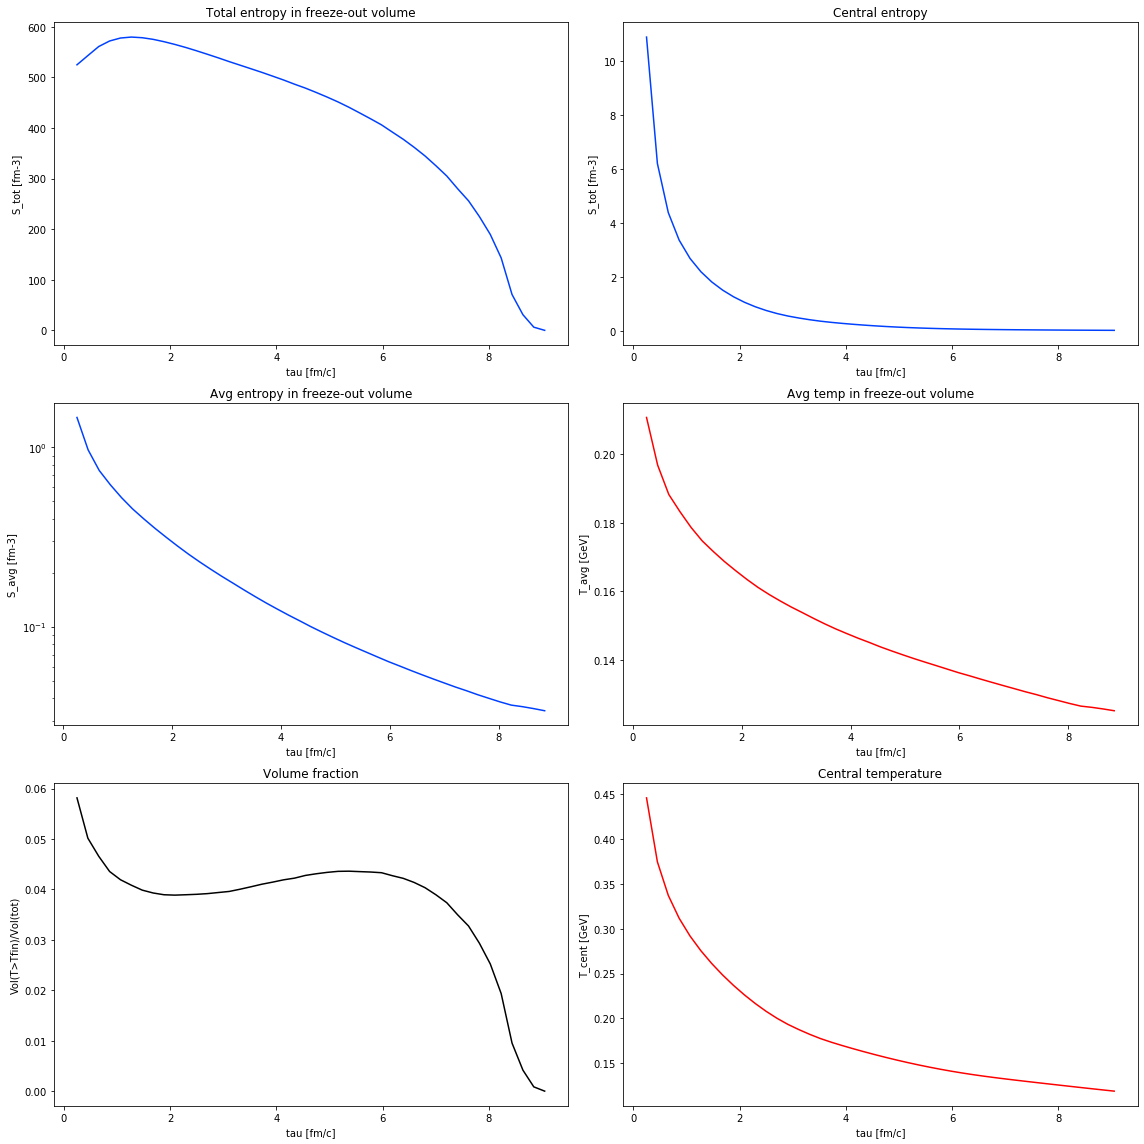

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))

# Total_s       Cent_s
# Avg_s_in      Avg_T_in
# Vol_frac      Cent_T

# Total_s

s = getEntropyFt(ini, d, intmD)
axs[0,0].plot(s[:,0],s[:,1],color='#0040FF')
axs[0,0].set_xlabel('tau [fm/c]')
axs[0,0].set_ylabel('S_tot [fm-3]')
axs[0,0].set_title('Total entropy in freeze-out volume')
 #total entropy inside freezeout


# Avg_s_in

sIn = getAvgEntropyInFt(ini, d, intmD)
axs[1,0].plot(sIn[:,0],sIn[:,1],color='#0040FF')
axs[1,0].set_yscale('log')
axs[1,0].set_xlabel('tau [fm/c]')
axs[1,0].set_ylabel('S_avg [fm-3]')
axs[1,0].set_title('Avg entropy in freeze-out volume')
 #Avg entropy in freezeout

# Vol_frac 

VF = getVFrac(ini, d)
axs[2,0].plot(VF[:,0],VF[:,1],color='#000000')
#axs[2,0].set_yscale('log')
axs[2,0].set_xlabel('tau [fm/c]')
axs[2,0].set_ylabel('Vol(T>Tfin)/Vol(tot)')
axs[2,0].set_title('Volume fraction')

# Cent_s

sC = getCentralEntropy(ini, d, intmD)
axs[0,1].plot(sC[:,0],sC[:,1],color='#0040FF')
#axs[0,1].set_yscale('log')
axs[0,1].set_xlabel('tau [fm/c]')
axs[0,1].set_ylabel('S_tot [fm-3]')
axs[0,1].set_title('Central entropy')
 # Central entropy


# Avg_T_in

TIn = getAvgTempInFt(ini, d)
axs[1,1].plot(TIn[:,0],TIn[:,1]*hbarc,color='#FD0000')
#axs[1,1].set_yscale('log')
axs[1,1].set_xlabel('tau [fm/c]')
axs[1,1].set_ylabel('T_avg [GeV]')
axs[1,1].set_title('Avg temp in freeze-out volume')
#Avg entropy in freezeout

# Cent_T

cT = getTCent(ini, d)
axs[2,1].plot(cT[:,0],cT[:,1]*hbarc,color='#FD0000')
#axs[2,1].set_yscale('log')
axs[2,1].set_xlabel('tau [fm/c]')
axs[2,1].set_ylabel('T_cent [GeV]')
axs[2,1].set_title('Central temperature')
 # Central temp

    
plt.tight_layout()
plt.show()


In [12]:
### Rapidity dependence (Z coord)

def getEntropyFzt(conf, bA, mI):
    tP = np.arange(conf['TPts'])
    zP = np.arange(conf['ZPts'])
    tPts = np.linspace(conf['TauMin'], conf['TauMin']+(conf['TauStepSize']*conf['RecordingFrequency']*conf['TPts']), conf['TPts'])
    sL = []
    for ti in tP:
        pL = []
        for zi in zP:
            Ti = bA[ti,:,:,zi].flatten()
            Tbool = np.heaviside(Ti-(conf['FinalTemperature']/hbarc),0)
            v = np.sum(Tbool * seq(Ti ,mI(Ti))) # heav(T>FinalTemperature) * seq
            pL.append(v*conf['XSpacing']*conf['YSpacing']*conf['ZSpacing']*tPts[ti]) # multiply by volume element size
        sL.append(pL)
    return np.array(sL)/conf['ZSpacing'] 



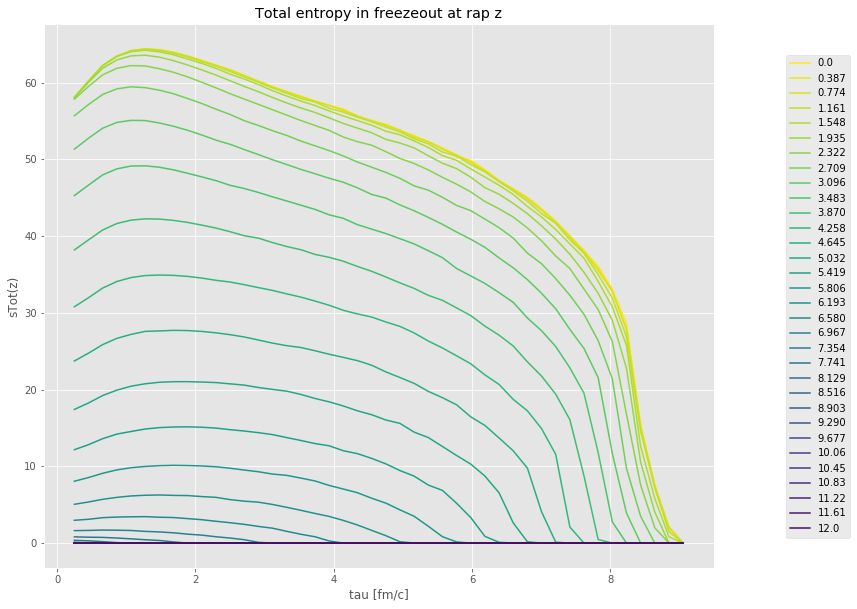

In [13]:
tPts = np.linspace(ini['TauMin'], ini['TauMin']+(ini['TauStepSize']*ini['RecordingFrequency']*ini['TPts']), ini['TPts'])
sZ = getEntropyFzt(ini, d, intmD)
ti = np.linspace
cmap = plt.get_cmap('viridis')
rapN = np.linspace(-1,0,6)
zTks = [(ini['ZPts']*ini['ZSpacing']/2)*i for i in rapN]
rN = np.linspace(0,1,32)*(ini['ZPts']*ini['ZSpacing']/2)
plt.style.use('ggplot')
#plt.style.use('dark_background')
plt.figure(figsize=(12,10))
for zi in range(32):
    plt.plot(tPts, sZ[:,zi+32], color=cmap(1-(2*zi/ini['ZPts'])), label=str(rN[zi])[:5])
#plt.style.use('dark_background')
plt.xlabel('tau [fm/c]')
plt.ylabel('sTot(z)')
plt.title('Total entropy in freezeout at rap z')
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#plt.tight_layout()
plt.show() #Entropy density function
plt.style.use('default')

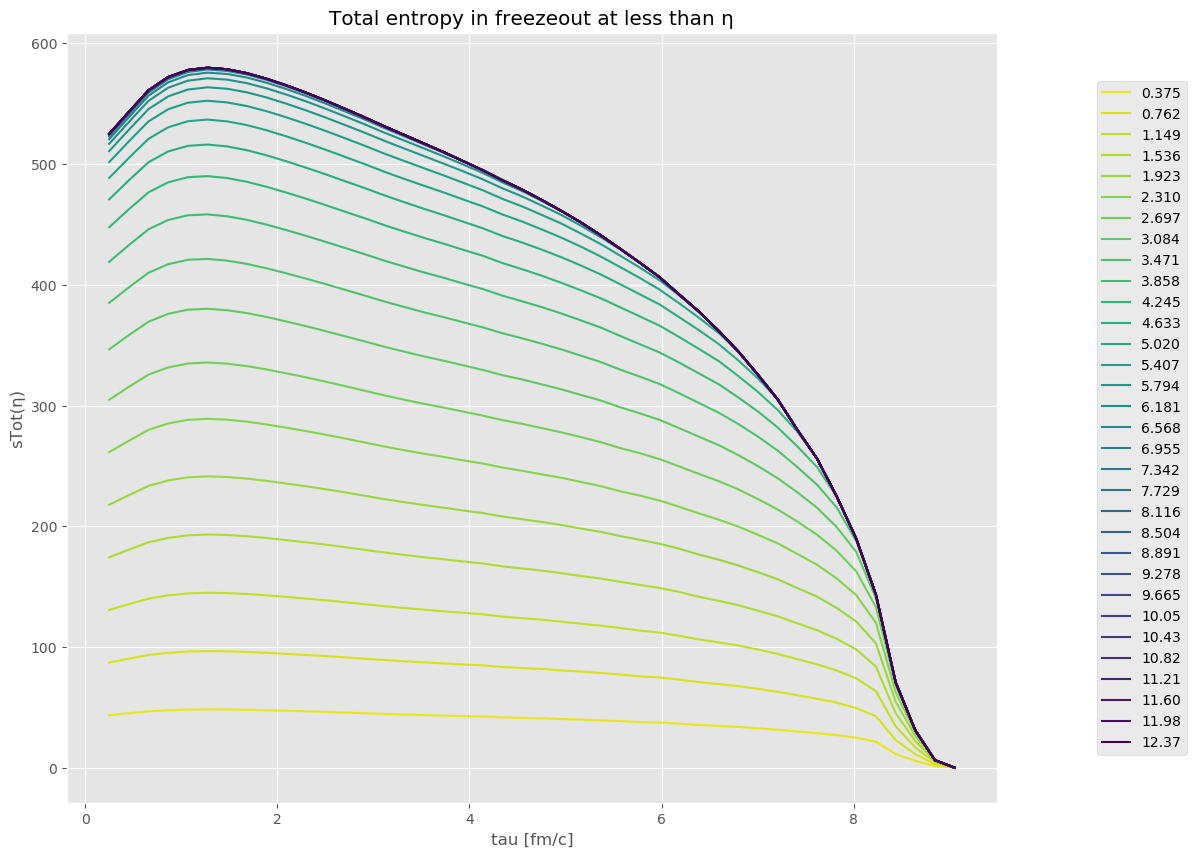

In [77]:
def getStotRap(conf, bA, mI):
    sZ = getEntropyFzt(conf, bA, mI)
    if conf['ZPts'] % 2 == 0: #even
        h = int(conf['ZPts']/2)
        fold = (sZ[:,h:] + np.flip(sZ[:,:h],axis=1))*conf['ZSpacing']
        return np.array([np.sum(fold[:,:zi],axis=1) for zi in range(1,1+h)])
    else:
        print('PANIC')

tPts = np.linspace(ini['TauMin'], ini['TauMin']+(ini['TauStepSize']*ini['RecordingFrequency']*ini['TPts']), ini['TPts'])
sZE = getStotRap(ini, d, intmD)
cmap = plt.get_cmap('viridis')
rN = np.linspace(0,1,32)*(ini['ZPts']*ini['ZSpacing']/2)+ini['ZSpacing']
plt.style.use('ggplot')
plt.figure(figsize=(12,10))

zi = 1
for etaLn in sZE:
    plt.plot(tPts, etaLn, color=cmap(1-(2*zi/ini['ZPts'])), label=str(rN[zi-1])[:5])
    zi+=1

plt.xlabel('tau [fm/c]')
plt.ylabel('sTot(η)')
plt.title('Total entropy in freezeout at less than η')
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.show() #Entropy in freezeout surface at z less than ...
plt.style.use('default')

In [74]:
k = getStotRap(ini, d, intmD)
print(k.shape)

(32, 44)


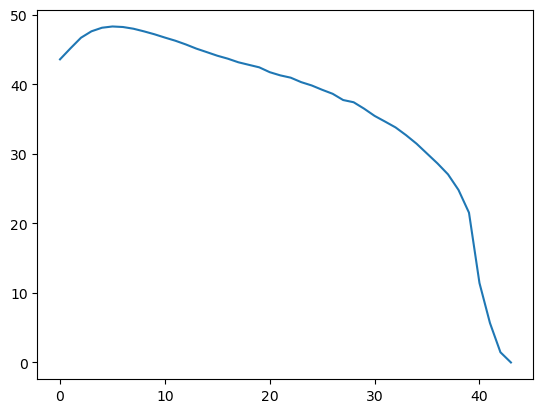

In [76]:
plt.plot(k[-1])